# 2023 Immune dataset H3K27me3

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts


## Load peaks

In [3]:
PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')

# IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
# TCell has too many peals
IMMUNE_CELLS = ['BCell', 'Monocyte']
MODIFICATIONS = ['H3K27me3']

! mkdir -p {PATH}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr

In [5]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 2


,file,modification,cell,fdr,peaks,avlength,tool
1,/home/jetbrains/data/2023_Immune/sicer/Monocyt...,H3K27me3,Monocyte,0.01,34547,6458.605754,SICER
0,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K27me3,Monocyte,0.05,57580,992.308267,MACS2
1,/home/jetbrains/data/2023_Immune/span/Monocyte...,H3K27me3,Monocyte,0.05,47143,4315.836307,SPAN
0,/home/jetbrains/data/2023_Immune/sicer/BCell_H...,H3K27me3,BCell,0.01,50127,6842.924432,SICER
1,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27me3,BCell,0.1,187656,617.866266,MACS2 broad


In [6]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

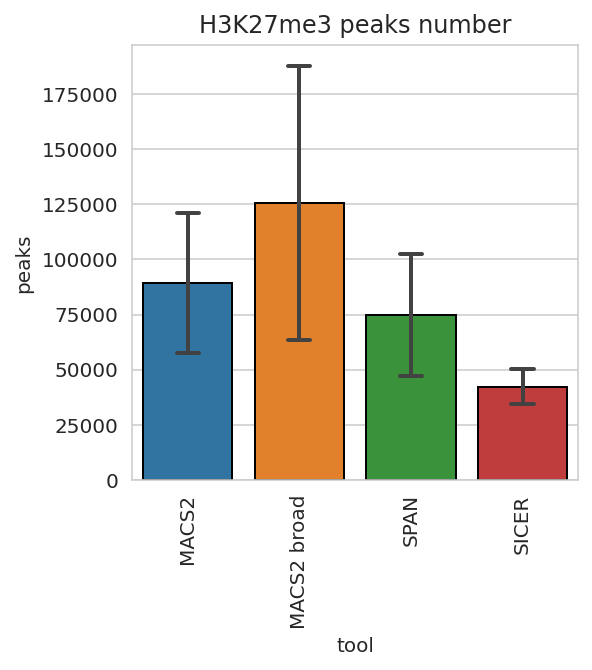

In [7]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=TOOLS)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27me3 peaks number')
plt.show()

In [26]:
print('Load lengths')
ts = []
for cell, file, tool in tqdm(zip(df_fdr_peaks['cell'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,cell,name
9842,255,Monocyte,MACS2
8987,294,Monocyte,MACS2
65661,750,BCell,SPAN
47666,4399,BCell,SICER
33667,1051,BCell,MACS2 broad
11639,658,BCell,MACS2
30150,409,BCell,MACS2 broad
42863,1599,BCell,SICER
62689,1770,BCell,SPAN
21611,360,Monocyte,MACS2 broad


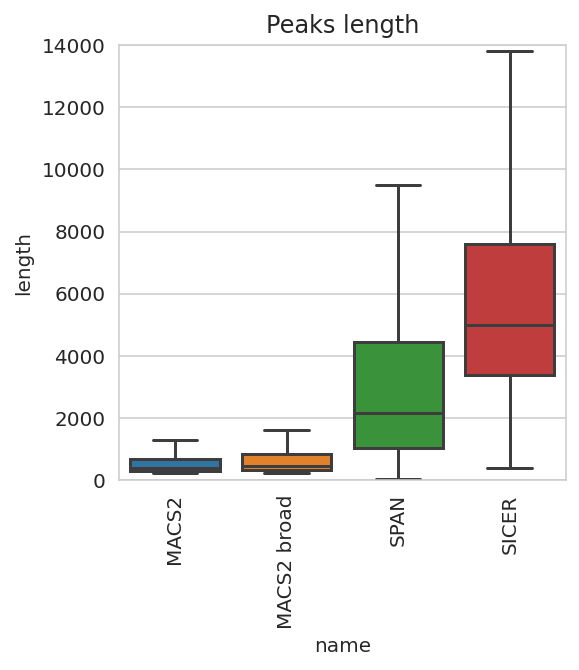

In [27]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='name', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False)
ax.title.set_text('Peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 14_000])
plt.show()

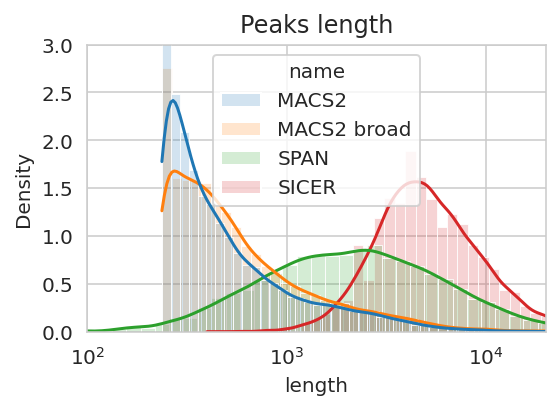

In [28]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=TOOLS)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

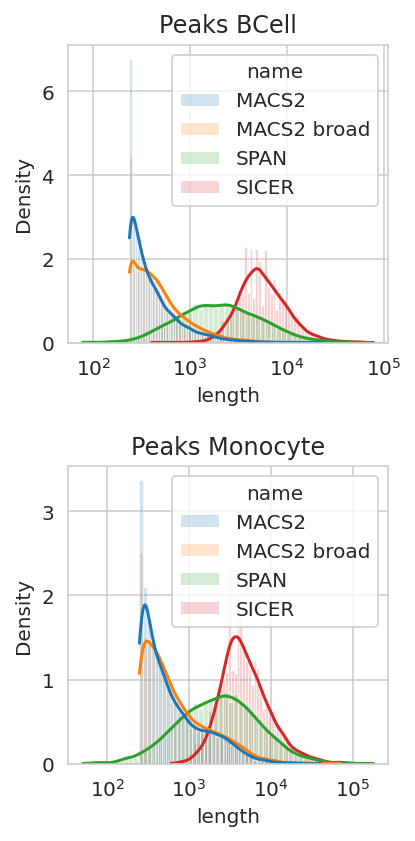

In [29]:
import math
experiments = [c for c in IMMUNE_CELLS if sum(t['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.histplot(data=t[t['cell'] == c],
                             x='length', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
# # Randomly tweak SPAN, SICER lengths for visualization purposes
# tsicer = t['name'] == 'SICER'
# t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))
# tspan = t['name'] == 'SPAN'
# t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))

In [12]:
# plt.figure(figsize=(8, 5))
# ax = plt.axes()
# g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
#                          stat='density', common_bins=False, common_norm=False,
#                          bins=200, kde=True, log_scale=True, alpha=0.2,
#                          palette=TOOLS_PALETTE)
# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 2e4)
# ax.title.set_text('H3K27me3 peaks length')
# plt.show()

In [13]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(3)

0it [00:00, ?it/s]

,tool,coverage
1,MACS2,62817094
0,MACS2,57137110
7,SPAN,203461471


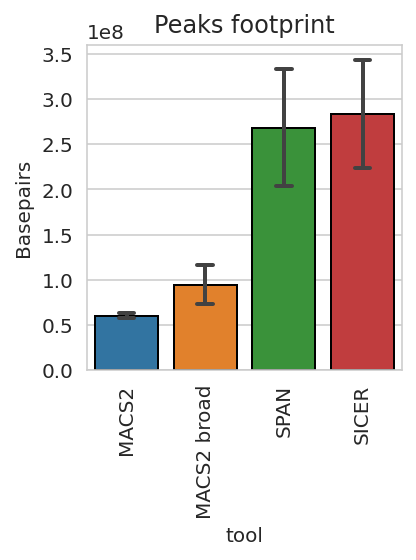

In [14]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Difference

In [21]:
tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name', 'peaks'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    for tool in df_fdr_peaks['tool'].unique():
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        bench_df.loc[len(bench_df)] = (c, tool, peaks)

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
diff_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K27me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in df_fdr_peaks['tool'].unique():
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !echo '' > {tf}
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (c, name, peaks)
diff_bench_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
Monocyte


,cell,name,peaks
0,BCell,SPAN - MACS2,53861
1,BCell,MACS2 - SPAN,2072
2,BCell,SPAN - MACS2 broad,26962
3,BCell,MACS2 broad - SPAN,14774
4,BCell,SPAN - SICER,40876
5,BCell,SICER - SPAN,387
6,Monocyte,SPAN - MACS2,28433
7,Monocyte,MACS2 - SPAN,10
8,Monocyte,SPAN - MACS2 broad,22310
9,Monocyte,MACS2 broad - SPAN,142


In [23]:
full_diff_bench_df = pd.concat([bench_df[['cell', 'name', 'peaks']],
                                diff_bench_df[['cell', 'name', 'peaks']]]).reset_index(drop=True)
full_diff_bench_df

,cell,name,peaks
0,BCell,MACS2,120947
1,BCell,MACS2 broad,187656
2,BCell,SICER,50127
3,BCell,SPAN,102270
4,Monocyte,MACS2,57580
5,Monocyte,MACS2 broad,63468
6,Monocyte,SICER,34547
7,Monocyte,SPAN,47143
8,BCell,SPAN - MACS2,53861
9,BCell,MACS2 - SPAN,2072


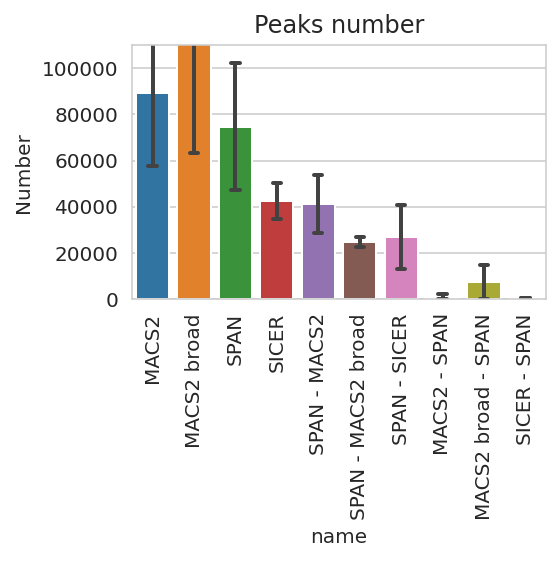

In [24]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_diff_bench_df, x='name', y='peaks',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(top=1.1e5)  # Limit for visual aesthetics
ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

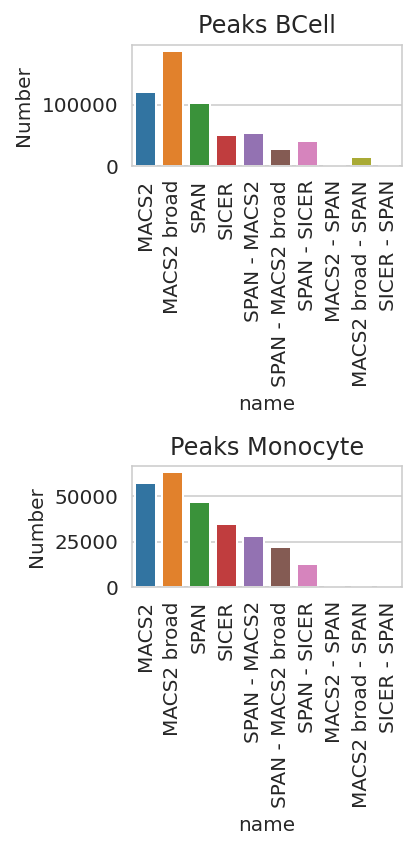

In [25]:
import math
experiments = [c for c in IMMUNE_CELLS
               if sum(full_diff_bench_df['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.barplot(data=full_diff_bench_df[full_diff_bench_df['cell'] == c],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Save benchmark

In [19]:
full_diff_bench_df.to_csv(PATH + '/H3K27me3_full_bench_df.csv.gz', index=False, compression='gzip')

 # Functional annotation

In [20]:
import tempfile

tf = tempfile.mktemp()

! rm -r {PATH}/summary_H3K27me3
! mkdir -p {PATH}/summary_H3K27me3

TOOLS = list(sorted(set(bench_df['name'])))

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{PATH}/summary_H3K27me3/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            !cat {tf} >> "{PATH}/summary_H3K27me3/{filename}.bed_"

for f in os.listdir(PATH + '/summary_H3K27me3'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{PATH}/summary_H3K27me3/{f}" | cut -f1-3 > "{PATH}/summary_H3K27me3/{f_sorted}"
    ! rm "{PATH}/summary_H3K27me3/{f}"

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
Monocyte


# Coverage

In [21]:
# Compute FRIP and other libraries features on full cells
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']

df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 3


,file,modification,cell,fdr,peaks,avlength,tool
0,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K27me3,Monocyte,0.05,57580,992.308267,MACS2
1,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27me3,BCell,0.05,120947,519.377033,MACS2
2,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K27me3,TCell,0.05,283089,441.589818,MACS2
2,/home/jetbrains/data/2023_Immune/sicer/Monocyt...,H3K27me3,Monocyte,0.01,34547,6458.605754,SICER
1,/home/jetbrains/data/2023_Immune/span/Monocyte...,H3K27me3,Monocyte,0.05,47143,4315.836307,SPAN


# Coverage

In [7]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = PATH + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [8]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K27me3')
display(bws_df.sample(1))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(1))

  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell
0,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,H3K27me3,BCell


  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell
1,/home/jetbrains/data/2023_Immune/bw/BCell_Cont...,Control,BCell


In [9]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [10]:
import tempfile
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27me3') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
MACS2 /tmp/tmpn_ql8k9t /home/jetbrains/data/2023_Immune/bw/BCell_H3K27me3_hg38_ENCFF118UGM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 broad /tmp/tmp0cgmicxs /home/jetbrains/data/2023_Immune/bw/BCell_H3K27me3_hg38_ENCFF118UGM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SPAN /tmp/tmp4bp5_k4f /home/jetbrains/data/2023_Immune/bw/BCell_H3K27me3_hg38_ENCFF118UGM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SICER /tmp/tmphj4r7wgk /home/jetbrains/data/2023_Immune/bw/BCell_H3K27me3_hg38_ENCFF118UGM.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
Monocyte
MACS2 /tmp/tmpv3z_8j35 /home/jetbrains/data/2023_Immune/bw/Monocyte_H3K27me3_gh38_ENCFF850DZD.bw /home/jetbrains/data/2023_Immune/bw/Monocyte_Control_hg38_ENCFF328STD.bw
MACS2 broad /tmp/tmp_i56lna6 /home/jetbrains/data/2023_Immune/bw/Monocyte_H3K27me3_gh38_ENCFF850DZD.bw /home/jetbrains/data/2023_Immune/bw/Monocyte_Contro

,cell,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,MACS2,/tmp/tmpn_ql8k9t,120947,62817094,1.147083e+07,8.490021e+07,1.536912e+06,8.484299e+07
1,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,MACS2 broad,/tmp/tmp0cgmicxs,187656,115946312,1.708760e+07,8.490021e+07,2.848180e+06,8.484299e+07
2,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,SPAN,/tmp/tmp4bp5_k4f,102270,333137830,3.122564e+07,8.490021e+07,9.477289e+06,8.485778e+07
3,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,SICER,/tmp/tmphj4r7wgk,50127,343015273,3.047155e+07,8.490021e+07,9.843273e+06,8.481521e+07
4,Monocyte,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,MACS2,/tmp/tmpv3z_8j35,57580,57137110,2.075331e+07,8.490034e+07,1.819105e+06,8.481244e+07
5,Monocyte,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,MACS2 broad,/tmp/tmp_i56lna6,63468,73399321,2.306956e+07,8.490034e+07,2.377653e+06,8.481244e+07
6,Monocyte,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,SPAN,/tmp/tmpmeyp68p4,47143,203461471,3.416000e+07,8.490034e+07,7.307461e+06,8.481546e+07
7,Monocyte,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,SICER,/tmp/tmp_335laon,34547,223125453,3.494770e+07,8.490034e+07,7.933702e+06,8.478965e+07


In [11]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

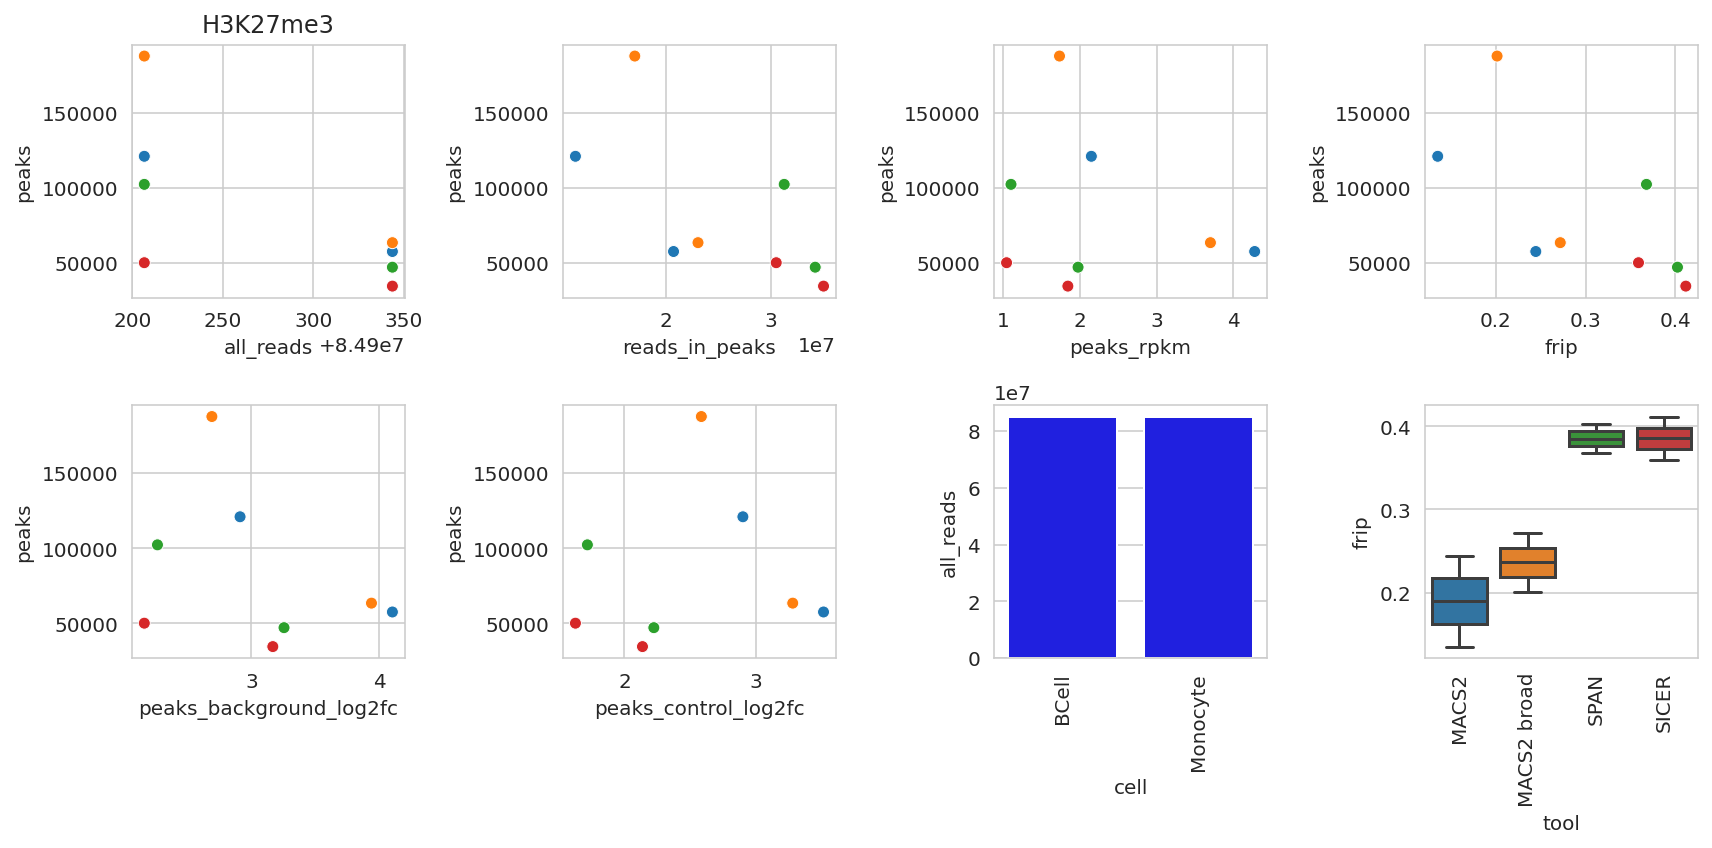

In [12]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K27me3')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{PATH}/pics/H3K27me3_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
frip_df.to_csv(f'{PATH}/pics/H3K27me3_frip.csv.gz', index=None, compression='gzip')

## Peaks density

In [13]:
import pyBigWig
import tempfile

tf = tempfile.mktemp()

coverage_data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = bws_df[(bws_df['modification'] == 'H3K27me3') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27me3', c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27me3', c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27me3', c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27me3', c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
Monocyte


,modification,cell,name,position,length,type,coverage,total_coverage
1488523,H3K27me3,Monocyte,SPAN,chr1:13987013-13990099,3086,control,146.254762,8.481546e+07
1038515,H3K27me3,BCell,SPAN - MACS2 broad,chr11:120632502-120633494,992,treatment,64.782977,8.490021e+07
1566403,H3K27me3,Monocyte,SICER,chr8:25049000-25055399,6399,treatment,612.804564,8.490034e+07
286787,H3K27me3,BCell,MACS2 broad,chr2:111916803-111917130,327,control,4.246814,8.484299e+07
805808,H3K27me3,BCell,SPAN,chr7:6210011-6212499,2488,control,41.337889,8.485778e+07


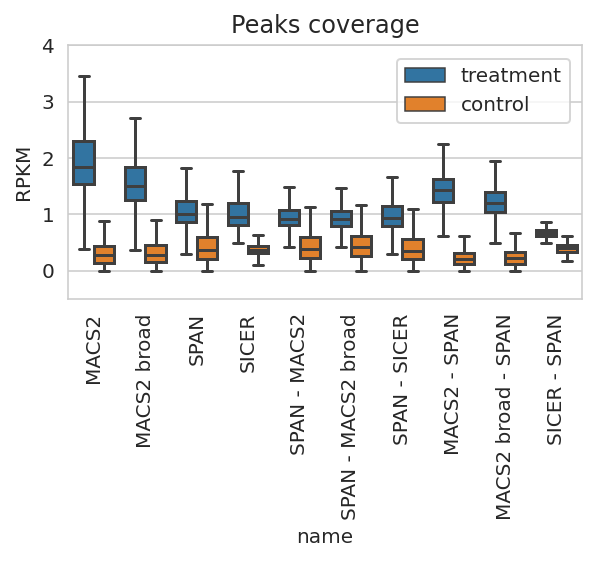

In [14]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-0.5, 4)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [30]:
CHROMHMM_MAP = {
    'BCell': PATH + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': PATH + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': PATH + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [31]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


,cell,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,BCell,MACS2 broad,187656,118,21,14306,100,3,3964,9286,...,148072,128117,39,4451,1541,983,221,1090,844,0
1,BCell,MACS2,120947,49,3,15712,53,3,1561,2379,...,104498,66212,14,4740,884,507,103,403,224,0
2,BCell,SICER,50127,333,63,8775,97,6,5050,7508,...,41689,41515,215,3336,2182,1528,498,1725,1653,0
3,BCell,SPAN,102270,311,50,9520,116,4,6149,12799,...,68783,68096,105,3538,2070,1537,408,1988,1855,0
4,BCell,SPAN - MACS2,53861,141,26,355,49,2,2524,7923,...,26832,26793,30,47,565,481,150,958,892,0
5,BCell,MACS2 - SPAN,2072,1,0,12,0,0,22,184,...,1071,1053,0,6,9,8,1,7,5,0
6,BCell,SPAN - MACS2 broad,26962,80,13,71,26,0,1247,3907,...,10941,10935,9,4,250,217,70,520,484,0
7,BCell,MACS2 broad - SPAN,14774,7,1,47,5,1,264,1670,...,6021,5979,5,15,88,67,21,118,101,0
8,BCell,SPAN - SICER,40876,86,11,327,26,1,1655,6116,...,18420,18319,20,82,411,349,101,644,594,0
9,BCell,SICER - SPAN,387,1,0,2,0,0,19,68,...,130,130,0,1,3,2,0,8,8,0


In [32]:
chrommm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
chrommm_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,336.333333,48.666667,14268.000000,56.000000,12.666667,1875.000000,1741.000000,9664.333333,131820.666667,84959.333333,101.333333,5439.666667,1266.666667,586.666667,474.000000,844.666667,628.333333,0.0
MACS2 broad,594.000000,76.666667,12955.666667,115.000000,35.333333,3702.000000,5058.333333,24039.000000,157050.333333,131226.666667,230.666667,5025.000000,2095.333333,1032.666667,842.666667,1700.666667,1317.000000,0.0
SPAN,706.666667,115.000000,9722.666667,114.333333,40.000000,4803.333333,5853.333333,26084.333333,91474.666667,84433.666667,308.333333,4264.666667,2276.000000,1292.000000,982.333333,1972.666667,1766.000000,0.0
SICER,821.333333,152.333333,8472.666667,110.333333,27.000000,4574.333333,3997.000000,13229.666667,40630.000000,40253.333333,347.333333,3876.333333,2310.000000,1392.666667,983.666667,1965.000000,1876.000000,0.0
SPAN - MACS2,292.000000,43.333333,420.666667,50.333333,27.000000,1907.333333,3298.666667,17743.666667,24581.333333,24318.666667,149.666667,117.333333,727.000000,406.333333,396.666667,908.000000,815.333333,0.0
SPAN - MACS2 broad,172.333333,28.666667,163.666667,31.000000,17.666667,1035.333333,1677.000000,11671.000000,10613.000000,10503.333333,91.333333,55.666667,381.000000,200.000000,218.666667,564.333333,510.333333,0.0
SPAN - SICER,184.000000,24.666667,311.333333,33.333333,24.000000,1152.333333,2712.666667,14379.666667,22617.666667,22269.000000,160.000000,113.000000,599.666667,316.000000,335.666667,552.666667,472.333333,0.0
MACS2 - SPAN,16.666667,0.000000,19.000000,3.666667,1.000000,59.333333,199.333333,1635.666667,3877.333333,3840.000000,8.333333,7.666667,47.000000,20.666667,23.666667,45.000000,26.666667,0.0
MACS2 broad - SPAN,109.666667,7.333333,74.666667,32.666667,15.666667,443.000000,1214.000000,8338.666667,15886.333333,15787.666667,62.666667,24.333333,286.666667,123.333333,167.666667,379.333333,250.666667,0.0


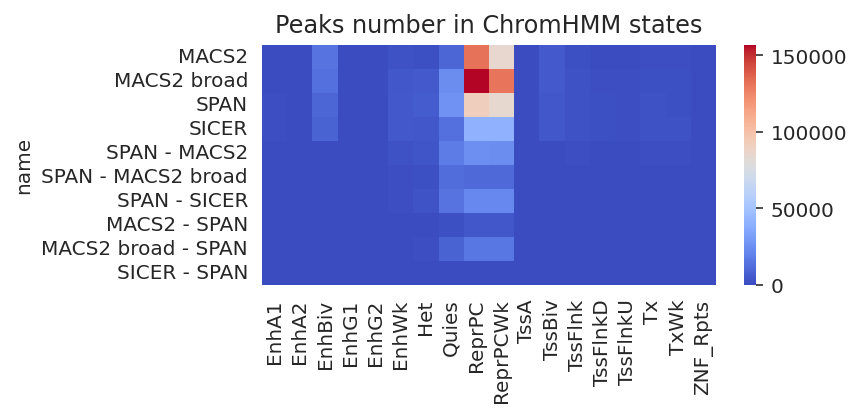

In [33]:
plt.figure(figsize=(6, 3))
sns.heatmap(chrommm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [34]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,0.003045,0.000610,0.120143,0.000480,0.000063,0.017554,0.011598,0.085052,0.832518,0.510815,0.000648,0.046924,0.009273,0.004136,0.003659,0.009675,0.007946,0.0
MACS2 broad,0.003832,0.000755,0.088013,0.000666,0.000123,0.024054,0.025061,0.159275,0.762545,0.612497,0.001081,0.036322,0.011398,0.005405,0.004770,0.013338,0.011287,0.0
SPAN,0.007744,0.001837,0.098827,0.001242,0.000248,0.054729,0.059048,0.334669,0.639844,0.601188,0.002592,0.045857,0.022431,0.012780,0.009635,0.026508,0.024787,0.0
SICER,0.016339,0.003439,0.172375,0.002291,0.000462,0.095020,0.080440,0.319174,0.756017,0.747411,0.006871,0.080041,0.045833,0.026896,0.019710,0.043244,0.041416,0.0
SPAN - MACS2,0.006722,0.001254,0.010126,0.001074,0.000508,0.043535,0.066750,0.445513,0.482315,0.476181,0.002807,0.003379,0.015753,0.008965,0.008510,0.022843,0.020983,0.0
SPAN - MACS2 broad,0.007250,0.001240,0.006995,0.001273,0.000739,0.042377,0.064694,0.483524,0.430158,0.425414,0.003804,0.002457,0.015819,0.008197,0.009172,0.023602,0.021381,0.0
SPAN - SICER,0.004997,0.000940,0.008669,0.000751,0.000362,0.034892,0.067222,0.471941,0.425067,0.416893,0.002489,0.003815,0.014570,0.008533,0.007479,0.020309,0.018559,0.0
MACS2 - SPAN,0.001178,0.000000,0.002864,0.000228,0.000062,0.006776,0.038191,0.503641,0.424740,0.386582,0.000519,0.001318,0.004187,0.002407,0.001613,0.003782,0.002361,0.0
MACS2 broad - SPAN,0.004108,0.002470,0.006629,0.000577,0.000252,0.020642,0.059235,0.515594,0.374147,0.364905,0.003369,0.000628,0.010524,0.005367,0.005222,0.010096,0.005528,0.0


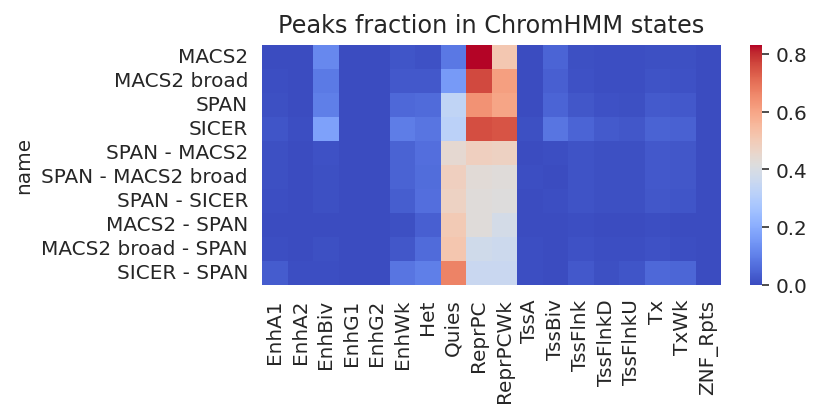

In [35]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()